# Autoencoder on Stock Market Data
### Dan Schmidt's Script Fall 2016

In [2]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)
%aimport preprocess
from preprocess.process import get_symbol
from preprocess.process import get_symbols_matrix
from preprocess.process import df_to_returns
from preprocess.process import get_windows_rets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from IPython.core.debugger import Tracer
import scipy as sp

from keras.models import Model
from keras.layers import Input, Dense
from keras.regularizers import l1, activity_l1, l2, activity_l2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using Theano backend.
Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5005, 5105))


In [3]:
# Load in the data
# Use tickers in the Dow Jones for most of this analysis
data_loc = "/home/dan/code/market_data/"
symbols = [line.rstrip('\n') for line in open(data_loc+'dow_jones_industrial.txt')]

train_start_date = "01/01/2013"
train_end_date = "12/31/2013"

test_start_date = "01/01/2014"
test_end_date = "01/31/2014"

test_symbols = symbols
window_length = 15

aapl = get_symbol("AAPL", data_loc, train_start_date, train_end_date)
aapl_rets, aaply_y = get_windows_rets(aapl, window_offset=1, window_length=window_length, forward=(1,2))

Reading AAPL from pickle
[(2013, 1, 3), (2013, 7, 3), (2013, 8, 22), (2013, 11, 29), (2013, 12, 24)]


## Define the Model

Train on 91512 samples, validate on 91512 samples
Epoch 1/64
91512/91512 [==============================] - 0s - loss: 0.8492 - val_loss: 0.7789
Epoch 2/64
91512/91512 [==============================] - 0s - loss: 0.7642 - val_loss: 0.7553
Epoch 3/64
91512/91512 [==============================] - 0s - loss: 0.7499 - val_loss: 0.7445
Epoch 4/64
91512/91512 [==============================] - 0s - loss: 0.7282 - val_loss: 0.7027
Epoch 5/64
91512/91512 [==============================] - 0s - loss: 0.6932 - val_loss: 0.6868
Epoch 6/64
91512/91512 [==============================] - 0s - loss: 0.6827 - val_loss: 0.6784
Epoch 7/64
91512/91512 [==============================] - 0s - loss: 0.6700 - val_loss: 0.6544
Epoch 8/64
91512/91512 [==============================] - 0s - loss: 0.6288 - val_loss: 0.6021
Epoch 9/64
91512/91512 [==============================] - 0s - loss: 0.5869 - val_loss: 0.5768
Epoch 10/64
91512/91512 [==============================] - 0s - loss: 0.5713 - val_loss: 0.5666

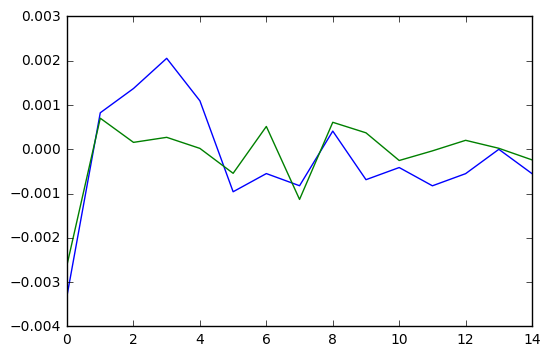

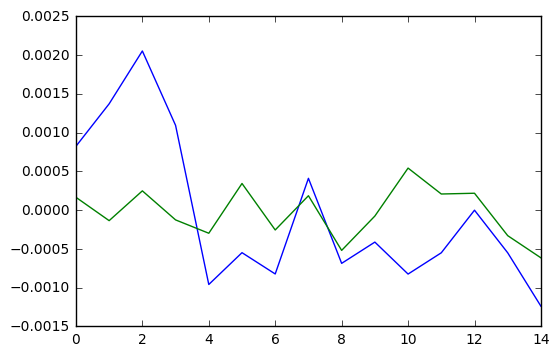

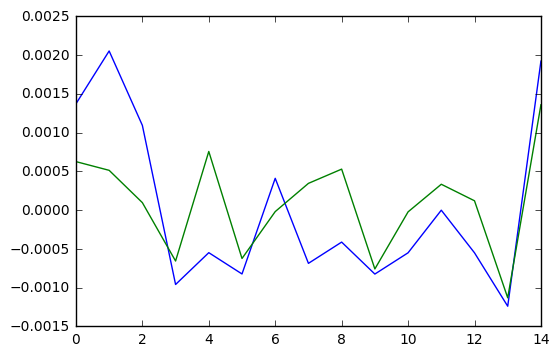

In [4]:
# Define some parameters
#
# Using perfect reconstruction to show an autoencoder can work
encoding_dim = 10


input_w = Input(shape=(window_length,))

reg = 0
encoded = Dense(
    window_length,
    init='normal', 
    activation='tanh',
    W_regularizer=l1(reg))(input_w)

encoded_mid = Dense(
    encoding_dim,
    init='normal',
    activation='tanh')(encoded)

decoded_mid = Dense(
    encoding_dim,
    init='normal',
    activation='tanh')(encoded_mid)

decoded = Dense(
    window_length,
    init='normal',
    activation='linear')(decoded_mid)

w_autoencoder = Model(input=input_w, output=decoded)
w_autoencoder.compile(optimizer='adagrad', loss='mse')
w_autoencoder.fit(
    aapl_rets / np.std(aapl_rets), 
    aapl_rets / np.std(aapl_rets), 
    batch_size=512,
    nb_epoch=64,
    shuffle=True, 
    validation_data=(aapl_rets / np.std(aapl_rets), aapl_rets/np.std(aapl_rets)) 
)

reconstructed = w_autoencoder.predict(aapl_rets/np.std(aapl_rets))*np.std(aapl_rets)

for i in range(3):
    plt.plot(aapl_rets[i, :])
    plt.plot(reconstructed[i, :])
    plt.show()

theano.tensor.var.TensorVariable

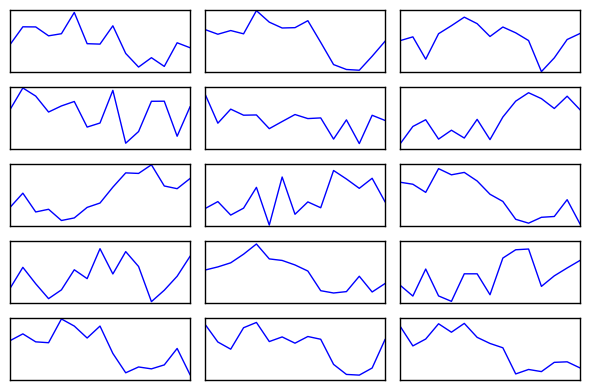

In [7]:
# Visualize the learned features

w0 = w_autoencoder.get_weights()[0]

fig, axes = plt.subplots(nrows=5, ncols=3)
ri = 0
ci = 0
for wi in range(len(w0)):
    learned = w0[:, wi]
    axes[ri, ci].plot((1+learned).cumprod())
    axes[ri, ci].get_xaxis().set_visible(False)
    axes[ri, ci].get_yaxis().set_visible(False)
    ci += 1
    if ci == 3:
        ri += 1
        ci = 0
plt.tight_layout()
plt.savefig('autoencoder_features.png')
plt.show()